In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from datetime import date
date.today()

datetime.date(2017, 8, 29)

In [3]:
author = "kyubyong. https://github.com/Kyubyong/tensorflow-exercises"

In [4]:
tf.__version__

'1.3.0'

In [5]:
np.__version__

'1.13.1'

In [6]:
sess = tf.InteractiveSession()

Notation:
For convenience, the name of numpy arrays starts with _ such as _x, _y.

You need to install **ffmpeg** beforehand!

### Basic Settings

In [7]:
# audio file path
audio_f = librosa.util.example_audio_file() # file path
sr = 22050 # sample rate
file_format = "ogg" # or wav, ...
num_channels = 1 # mono
n_fft = 2048 # number of fft length. 2**n
win_length = 1000 # window length <= n_fft
hop_length = 250 # hopping step
n_mels = 80 # number of mels
n_mfccs = 40 # number of mfccs
preemp = .97 # preemphasis rate
n_iter = 50 # Griffin-Lim's law


# Data load

In [8]:
# librosa
_y, sr = librosa.load(audio_f, sr=sr, mono=num_channels==1)
_y.shape

(1355168,)

In [9]:
# TF
def data_load(audio_f, sr=22050, file_format="wav", num_channels=1):
    audio_binary = tf.read_file(audio_f)
    y = tf.contrib.ffmpeg.decode_audio(audio_binary, file_format, sr, num_channels)
    return tf.squeeze(y, 1), sr

y, sr = data_load(audio_f, sr, file_format, num_channels)
y.eval().shape    

(1355168,)

# Preemphasis

For theoretical explanations, check [this](https://www.quora.com/Why-is-pre-emphasis-i-e-passing-the-speech-signal-through-a-first-order-high-pass-filter-required-in-speech-processing-and-how-does-it-work)

In [10]:
# Librosa
def _preemphasize(y, rate=.97):
    '''
    y: 1-D array. Waveform.
    rate: A python scalar. 
    '''
    y = np.append(y[0], y[1:]-rate*y[:-1])
    return y

_y = _preemphasize(_y, preemp)

In [11]:
# TF
def preemphasize(y, rate=.97):
    '''
    y: 1-D tensor. Waveform.
    rate: A python scalar.
    '''
    y = tf.concat((y[:1], y[1:]-rate*y[:-1]), -1)
    return y

y = preemphasize(y, preemp)

For demonstration, we use the first 100,000 samples.

In [12]:
_y = _y[:100000]
y = y[:100000]

# Spectrograms

Note that the output shape is the opposite in librosa and TF.

In [15]:
# librosa
def _get_spectrograms(y, sr=22050, n_fft=2048, win_length=2048, hop_length=512, n_mels=None, power=1):
    linear = librosa.stft(y, n_fft=n_fft, win_length=win_length, hop_length=hop_length) # linear spectrogram
    mag = np.abs(linear) # magnitude 
    
    if n_mels is not None:
        mel_basis = librosa.filters.mel(sr, n_fft, n_mels) # (n_mels, 1+n_fft//2)
        mel = np.dot(mel_basis, mag**power) # (n_mels, t) # mel spectrogram
    else:
        mel = None
    
    return linear, mag, mel

_linear, _mag, _mel = _get_spectrograms(_y, sr, n_fft, win_length, hop_length, n_mels)
print(_linear.shape, _mag.shape, _mel.shape)

(1025, 401) (1025, 401) (80, 401)


In [16]:
# TF
def get_spectrograms(y, sr=22050, n_fft=2048, win_length=2048, hop_length=512, n_mels=None, power=1):
    linear = tf.contrib.signal.stft(y, frame_length=win_length, frame_step=hop_length, fft_length=n_fft) # linear spectrogram
    mag = tf.abs(linear) # magnitude
    
    if n_mels is not None:
        mel_basis = tf.convert_to_tensor(librosa.filters.mel(sr, n_fft, n_mels), tf.float32)
        mel = tf.matmul(mag**power, mel_basis, transpose_b=True) # (t, n_mels)
    else:
        mel = None
    
    return linear, mag, mel
linear, mag, mel = get_spectrograms(y, sr, n_fft, win_length, hop_length, n_mels)
print(linear.eval().shape, mag.eval().shape, mel.eval().shape)

(397, 1025) (397, 1025) (397, 80)


# MFCC

In [17]:
# Librosa
def _get_mfccs(y, sr=22050, n_fft=2048, win_length=2048, hop_length=512, n_mels=128, n_mfccs=20):
    _, _, mel = _get_spectrograms(y, sr, n_fft, win_length, hop_length, n_mels, power=2)
    mel = librosa.power_to_db(mel)
    mfccs = np.dot(librosa.filters.dct(n_mfccs, mel.shape[0]), mel)
    return mfccs

_mfccs = _get_mfccs(_y, sr, n_fft, win_length, hop_length, n_mels, n_mfccs)

In [18]:
# TF
# Adapted from https://librosa.github.io/librosa/_modules/librosa/core/spectrum.html#power_to_db
def power2db(power, ref_value=1.0, amin=1e-10, top_db=80.0):
    if amin <= 0:
        raise ParameterError('amin must be strictly positive')

    def _log10(x):
        numerator = tf.log(x)
        denominator = tf.log(tf.constant(10, dtype=numerator.dtype))
        return numerator / denominator

    log_spec = 10.0 * _log10(tf.maximum(amin, power))
    log_spec -= 10.0 * _log10(tf.maximum(amin, ref_value))

    if top_db is not None:
        if top_db < 0:
            raise ParameterError('top_db must be non-negative')
        log_spec = tf.maximum(log_spec, tf.reduce_max(log_spec) - top_db)

    return log_spec


In [19]:
def get_mfccs(y, sr=22050, n_fft=2048, win_length=2048, hop_length=512, n_mels=128, n_mfccs=20):
    _, _, mel = get_spectrograms(y, sr, n_fft, win_length, hop_length, n_mels, power=2)
    mel = power2db(mel)
    
    # get mfccs
    basis = tf.convert_to_tensor(librosa.filters.dct(n_mfccs, n_mels), tf.float32) # (n_mfccs, n_mels)
    mfccs = tf.matmul(mel, basis, transpose_b=True) # => (t, n_mfccs)
    
    return mfccs

mfccs = get_mfccs(y, sr, n_fft, win_length, hop_length, n_mels, n_mfccs)
    

Let's check if those two types of mfccs are close enough.

In [20]:
print(_mfccs.sum(), "===", mfccs.eval().sum())
print(_mfccs.max(), "===", mfccs.eval().max())
print(_mfccs.min(), "===", mfccs.eval().min())

-121191.609551 === -118951.0
192.720920232 === 190.608
-722.122949129 === -721.386


# Griffin-Lim's Law

In [21]:
# Librosa
def _spectrogram2wav(spectrogram, n_iter=50, n_fft=2048, win_length=2048, hop_length=512):
    '''Converts spectrogram into a waveform using Griffin-lim's raw.
    '''
    def invert_spectrogram(spectrogram):
        '''
        spectrogram: [f, t]
        '''
        return librosa.istft(spectrogram, hop_length, win_length)

    import copy
    X_best = copy.deepcopy(spectrogram)  # [f, t]
    for i in range(n_iter):
        X_t = invert_spectrogram(X_best)
        est = librosa.stft(X_t, n_fft, hop_length, win_length)  # [f, t]
        phase = est / np.maximum(1e-8, np.abs(est))  # [f, t]
        X_best = spectrogram * phase  # [f, t]
    X_t = invert_spectrogram(X_best)
    y = np.real(X_t)

    return y



Recontruct the waveform.

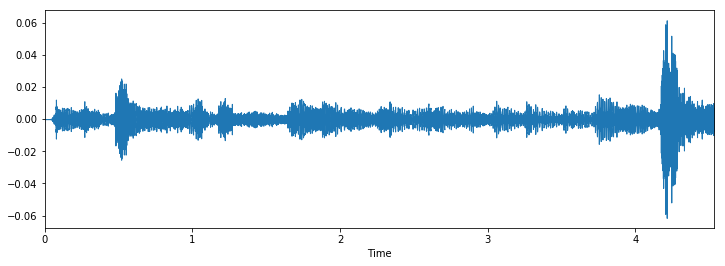

In [22]:
_wav = _spectrogram2wav(_mag, n_iter, n_fft, win_length, hop_length)
plt.figure(figsize=(12, 4))
librosa.display.waveplot(_wav, sr)
ipd.Audio(_wav, rate=sr)

In [23]:
# TF
def spectrogram2wav(spectrogram, n_iter=50, n_fft=2048, win_length=2048, hop_length=512):
    '''Converts spectrogram into a waveform using Griffin-lim's raw.
    '''
    def invert_spectrogram(spectrogram):
        '''
        spectrogram: [t, f]
        '''
        spectrogram = tf.expand_dims(spectrogram,0)
        inversed = tf.contrib.signal.inverse_stft(spectrogram, win_length, hop_length, n_fft)
        squeezed = tf.squeeze(inversed, 0)
        return squeezed
    
    spectrogram = tf.cast(spectrogram, dtype=tf.complex64)  # [t, f]
    X_best = tf.identity(spectrogram)
    for i in range(n_iter):
        X_t = invert_spectrogram(X_best)
        est = tf.contrib.signal.stft(X_t, win_length, hop_length, n_fft, pad_end=False) # (1, T, n_fft/2+1)
        phase = est / tf.cast(tf.maximum(1e-8, tf.abs(est)), tf.complex64) # [t, f]
        X_best = spectrogram * phase  # [t, t]
    X_t = invert_spectrogram(X_best)
    y = tf.real(X_t)

    return y

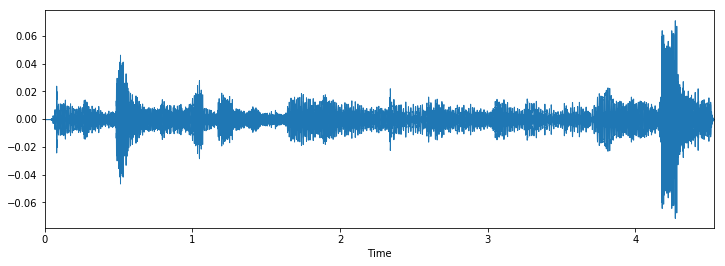

In [24]:
wav = spectrogram2wav(mag, n_iter, n_fft, win_length, hop_length)
plt.figure(figsize=(12, 4))
wav = wav.eval()
librosa.display.waveplot(wav, sr)
ipd.Audio(wav, rate=sr)